# La Paloma power generation analysis

By [Ben Welsh](mailto:ben.welsh@latimes.com) and [Ryan Menezes](mailto:ryan.menezes@latimes.com)

A June 9, 2017 story in the Los Angeles Times titled ["Foo bar"]() examined the decline in production at the La Paloma natural-gas power plant near Bakersfield. The data are drawn from [a past Times analysis](analysis.ipynb) of federal data. 

In [37]:
import os
import pandas as pd

In [38]:
%matplotlib inline

In [39]:
pd.options.display.float_format = "{:,.2f}".format

In [40]:
data_dir = os.path.join(os.getcwd(), 'data', 'output')

### Read in data from our previous analysis

In [41]:
latimes_df = pd.read_csv(
    os.path.join(data_dir, "plants-california.csv"),
)

In [42]:
trimmed_latimes_columns = [
    'plant_id',
    'plant_name_gen',
    'year',
    'net_generation_mwh',
    'capacity_mwh',
    'capacity_utilization'
]

In [43]:
trimmed_latimes_df = latimes_df[trimmed_latimes_columns]

### Finding: La Paloma is the state's 2nd most productive power plant over the past decade 

In [44]:
trimmed_latimes_df[
    (trimmed_latimes_df.year > 2005)
].groupby([
    'plant_id',
    'plant_name_gen'
]).net_generation_mwh.sum().reset_index().sort_values(
    "net_generation_mwh",
    ascending=False
).head(10)

,plant_id,plant_name_gen,net_generation_mwh
239,"6,099.00",Diablo Canyon,"178,547,139.00"
695,"55,151.00",La Paloma Generating LLC,"54,465,060.00"
49,260.00,Dynegy Moss Landing Power Plant,"49,206,313.00"
706,"55,333.00",Delta Energy Center,"49,095,193.00"
128,360.00,San Onofre Nuclear Generating Station,"48,054,769.00"
74,286.00,Geysers Unit 5-20,"46,922,933.00"
127,360.00,San Onofre,"46,270,572.00"
718,"55,518.00",High Desert Power Plant,"39,775,484.00"
156,400.00,Haynes,"36,762,820.00"
711,"55,400.00",Elk Hills Power LLC,"36,470,168.00"


### Finding: La Paloma's production has declined in recent years

Since our previous analysis did not include 2016 generation totals, we will need to read those in from the EIA

In [45]:
eia_df = pd.read_excel(
    "data/input/EIA923_Schedules_2_3_4_5_M_12_2016.xlsx",
    sheetname='Page 1 Generation and Fuel Data',
    skiprows=5
)

In [46]:
trimmed_eia_columns = [
    'Plant Id',
    'Plant Name',
    'Plant State',
    'Net Generation\n(Megawatthours)'
]

In [47]:
trimmed_eia = eia_df[trimmed_eia_columns]

In [48]:
trimmed_eia.columns = ['id', 'name', 'state', 'net_generation_mwh']

In [49]:
california_2016 = trimmed_eia[trimmed_eia.state == 'CA']

In [50]:
ranker_2016 = california_2016.groupby(["id", "name"]).net_generation_mwh.sum().reset_index()

Now filter down to only La Paloma from our existing data

In [51]:
la_paloma = trimmed_latimes_df[trimmed_latimes_df.plant_id == 55151]

In [52]:
trimmed_la_paloma = la_paloma.drop(['plant_id', 'plant_name_gen'], axis=1)

Then append the 2016 generation value along with its utilization

In [53]:
la_paloma_2016_gen = ranker_2016.set_index("id").at[55151, 'net_generation_mwh']

In [54]:
la_paloma_2016_cap = trimmed_la_paloma.set_index("year").at[2015.0, 'capacity_mwh']

In [55]:
la_paloma_2016_util = la_paloma_2016_gen / la_paloma_2016_cap

In [56]:
la_paloma_2016_df = pd.DataFrame([[
    2016.0,
    la_paloma_2016_gen,
    la_paloma_2016_cap,
    la_paloma_2016_util
]], columns=trimmed_la_paloma.columns)

In [57]:
combined_la_paloma = trimmed_la_paloma.append(la_paloma_2016_df)

Now examine the combined result

In [58]:
combined_la_paloma.tail(5)

,year,net_generation_mwh,capacity_mwh,capacity_utilization
8908,"2,012.00","5,471,800.00","8,456,904.00",0.65
9913,"2,013.00","6,570,936.00","8,456,904.00",0.78
11375,"2,014.00","6,558,024.00","8,456,904.00",0.78
12622,"2,015.00","5,342,223.00","8,456,904.00",0.63
0,"2,016.00","4,236,172.00","8,456,904.00",0.50


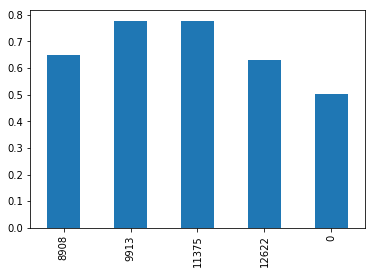

In [59]:
combined_la_paloma.tail(5).capacity_utilization.plot.bar()

### Finding: Due to it's declining business, La Paloma fell in the state production ranking last year

In [36]:
ranker_2016.sort_values("net_generation_mwh", ascending=False).head(11).tail(10)

,id,name,net_generation_mwh
65,6099,Diablo Canyon,"18,907,578.00"
32,358,Mountainview Generating Station,"4,890,772.00"
18,286,Geysers Unit 5-20,"4,628,971.00"
137,55656,"Pastoria Energy Facility, LLC","4,365,684.00"
128,55151,La Paloma Generating LLC,"4,236,172.00"
140,55970,Cosumnes,"3,859,086.00"
132,55333,Delta Energy Center,"3,819,440.00"
129,55182,Sunrise Power LLC,"3,517,950.00"
135,55400,Elk Hills Power LLC,"3,442,847.00"
40,400,Haynes,"3,368,110.00"
